# Interpretation of results
In this notebook we interpret the results obtained in **do-simulations.ipynb**:

1. Plot model predictions
2. Plot imputed true difference graph and corresponding confidence bands of null distributions.
3. Test statistical significance of *systematic bias* and *cumulative error*.
4. Find confidence intervals for effect size.

## Imports and data loading

In [3]:
import pandas as pd
import numpy as np
import scipy
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from indirect_utils import get_delta, identity

%matplotlib inline

years = [_ for _ in range(1920, 1981)]

In [4]:
data_russian = pd.read_csv("data/russian.csv")
data_itm = pd.read_csv("data/ITM.csv")

In [5]:
delta_russian_perm = pd.read_csv("delta_russian_perm_gbr_splitted.csv")
delta_russian_bootstrap = pd.read_csv("delta_russian_bootstrap_gbr_splitted.csv")
pred_russian_full = pd.read_csv("pred_russian_full_gbr_splitted.csv")
delta_russian_full_logodds = get_delta(pred_russian_full, use_logodds=True)

In [6]:
delta_itm_perm = pd.read_csv("delta_itm_perm_gbr_splitted.csv")
delta_itm_bootstrap = pd.read_csv("delta_itm_bootstrap_gbr_splitted.csv")
pred_itm_full = pd.read_csv("pred_itm_full_gbr_splitted.csv")
delta_itm_full = get_delta(pred_itm_full, use_logodds=False)

In [7]:
pred_russian_full.columns

Index(['type', 'sex', 'residence', 'year_of_birth', 'language population',
       'village population', 'mother tongue', 'elevation', 'pred'],
      dtype='object')

In [15]:
pred_russian_full['village population'].value_counts().sort_index()

125.000000     236
127.000000     472
150.000000     236
175.000000     236
179.000000     236
180.000000     236
188.000000     236
196.000000     236
205.000000     236
249.000000     236
250.000000     236
258.000000     236
272.000000     236
273.000000     236
283.000000     236
295.000000     236
305.000000     236
309.000000     236
311.000000     236
327.000000     236
342.000000     236
345.000000     236
397.000000     236
403.000000     236
408.000000     236
411.000000     236
504.000000     236
510.000000     236
579.000000     236
653.000000     236
663.677966     472
710.000000     236
780.000000     236
787.000000     236
836.000000     236
885.000000     236
916.000000     236
1041.000000    236
1058.000000    236
1195.000000    236
1197.000000    236
1223.000000    236
1262.000000    236
1456.000000    236
1467.000000    236
1733.000000    236
1769.000000    236
2430.000000    472
3162.000000    236
Name: village population, dtype: int64

## Function definitions

In [5]:
def ci(series, beta=0.95):
    """
    Finds an interval that takes proprotion of beta of the distribution in series
    """
    alpha = 1 - beta
    return (series.quantile(alpha / 2), series.quantile(1 - alpha / 2))

In [6]:
def confint(delta_df, beta=0.95):
    """
    This function is used to construct confidence band for null distribution
    For each year_of_birth it finds corresponding confidence interval
    """
    return (
        (
            delta_df.groupby("year_of_birth").agg(
                dict(
                    delta=(
                        ("low", lambda x: x.quantile((1 - beta) / 2)),
                        "mean",
                        ("high", lambda x: x.quantile(1 - (1 - beta) / 2)),
                    )
                )
            )
        )
        .droplevel(axis=1, level=0)
        .reset_index()
    )

In [31]:
def typelabel(df, label="type"):
    """
    Helper function for plotting
    """
    return df.assign(
        type=lambda x: x["type"].replace({0: "indirect", 1: "direct"})
    ).rename(columns={"type": label})


def plot_pred_data(data, full, target, ylabel, ylim, ylogodds=False):
    """
    Plots predictions along with data 
    (averaged by all other variable except year_of_birth)
    """

    plt.figure(figsize=(8, 6))

    def postprocess(df, y, hue):
        df = typelabel(df, hue)
        if ylogodds:
            df = tologodds(df, y)
        return df

    sns.scatterplot(
        x="year_of_birth",
        y="mean",
        size="count",
        hue="collected data",
        ci=None,
        data=(
            data.groupby(["year_of_birth", "type"])[target]
            .agg(("mean", "count"))
            .reset_index()
            .pipe(lambda x: postprocess(x, "mean", "collected data"))
        ),
    )

    sns.lineplot(
        x="year_of_birth",
        y="pred",
        hue="model prediction",
        style="model prediction",
        style_order=["direct", "indirect"],
        data=full.pipe(lambda x: postprocess(x, "pred", "model prediction")),
        ci=None,
    )

    plt.xlabel("Year of birth")
    plt.ylabel(ylabel)
    
    data.groupby(['year_of_birth', 'type'])[target].agg(('mean', 'count'))\
    .reset_index().pipe(lambda x: postprocess(x, "mean", "collected data"))\
    .to_csv('data/scatter_{}.csv'.format(target))
    full.pipe(lambda x: postprocess(x, "pred", "model prediction"))\
    .to_csv('data/line_{}.csv'.format(target))
    
    if ylim:
        plt.ylim(ylim)

In [30]:
def plot_delta(delta_df, delta_full, data, title):
    """
    Plots imputed true difference and confidence band
    """
    ci = confint(delta_df)
    minyear = min(delta_full["year_of_birth"])

    fig, (ax1, ax2) = plt.subplots(
        nrows=2, sharex=True, figsize=(10, 7), gridspec_kw=dict(height_ratios=[2, 1])
    )

    ax1.plot(
        ci["year_of_birth"] - minyear, np.zeros_like(ci["year_of_birth"]), color="grey"
    )
    ax1.fill_between(
        ci["year_of_birth"] - minyear, ci["low"], ci["high"], alpha=0.2, color="grey"
    )
    delta_full.groupby("year_of_birth")["delta"].mean().reset_index(drop=True).plot(
        color="red", ax=ax1
    )
    for i in range(5):
        ax1.plot(
            ci["year_of_birth"] - minyear,
            delta_df[lambda x: x["iter"] == i].groupby("year_of_birth")["delta"].mean(),
            color="grey",
            alpha=0.5,
        )
    ax1.set_ylabel("$indirect - direct$")

    sns.countplot(
        x="year_of_birth_int",
        hue="evidence type",
        data=typelabel(
            data_russian.assign(
                year_of_birth_int=lambda x: x["year_of_birth"].astype(int)
            ),
            "evidence type",
        ),
        ax=ax2,
    )

    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
    ax2.set_ylabel("number of observations")
    ax2.set_xlabel("year of birth")
    ax1.set_title(title)
    ci.to_csv('data/delta_{}_conf.csv'.format(title))
    delta_full.groupby('year_of_birth')['delta'].mean()\
    .reset_index(drop=True).to_csv('data/delta_{}.csv'\
                                   .format(title))

In [9]:
def test_hyp(
    delta_obs,
    delta_null,
    ax,
    stat_column="delta",
    stat_function=identity,
    agg_function=np.mean,
):
    """
    Tests hypothesis that delta_obs does not belong 
    to null distribution given by delta_null
    
    stat_function is applied to each value of delta 
    (it is usually identity or np.absolute)
    
    agg_function is aggregates the result 
    (it is usually np.mean but can be also np.max)
    """
    null_distribution = (
        delta_null.groupby("iter")[[stat_column]].agg(agg_function).reset_index()
    )
    stat_value = agg_function(stat_function(delta_obs["delta"]))

    print("statistics value:", stat_value)
    null_distribution[stat_column].hist(bins=50, ax=ax)
    ax.plot([stat_value], [5], "o", markersize=10)
    pvalue = (
        null_distribution.assign(
            in_tail=lambda x: (
                ((stat_value > x[stat_column].mean()) & (x[stat_column] > stat_value))
                | ((stat_value < x[stat_column].mean()) & (x[stat_column] < stat_value))
            )
        )["in_tail"].mean()
        * 2
    )
    return stat_value, pvalue
    # ax.set_title(f"Statistics value: {stat_value:0.4f}, p-value: {pvalue:0.4f}")

In [10]:
def test_all_hyps(
    delta_full,
    delta_df,
    statistics=(
        ("mean(·)", "delta", identity, np.mean),
        ("mean(abs(·))", "delta_absolute", np.abs, np.mean),
    ),
    queries=(None, "year_of_birth <= 1945", "year_of_birth > 1945"),
    suptitle=None,
    figsize=(12, 8),
):
    """
    Test a series of hypothesis for given dataset split and draws 
    corresponding figures
    """

    fig, axes = plt.subplots(
        len(statistics), len(queries), figsize=figsize, squeeze=False
    )
    emptyquery = "index == index or index != index"
    for i, (stat_name, stat_column, stat_function, agg_function) in enumerate(
        statistics
    ):
        for j, query in enumerate(queries):
            query_actual = query if query else emptyquery
            query_name = query.replace("<=", "≤") if query else "Full dataset"

            stat_value, pvalue = test_hyp(
                delta_obs=delta_full.query(query_actual),
                delta_null=delta_df.query(query_actual),
                stat_column=stat_column,
                stat_function=stat_function,
                agg_function=agg_function,
                ax=axes[i, j],
            )
            axes[i, j].set_title(f"{query_name}\n" f"pvalue = {pvalue}")
    if suptitle:
        fig.suptitle(suptitle)

## Russian

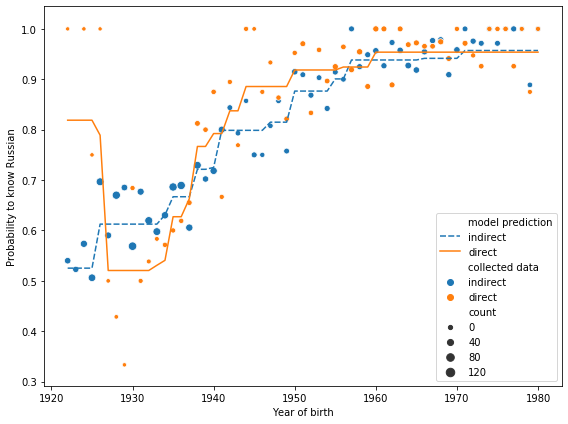

In [11]:
plot_pred_data(
    data=data_russian,
    full=pred_russian_full,
    target="русский",
    ylabel="Probability to know Russian",
    ylim=None,
    ylogodds=False,
)
plt.tight_layout()
# plt.savefig("plot_pred_data_rusian.png")

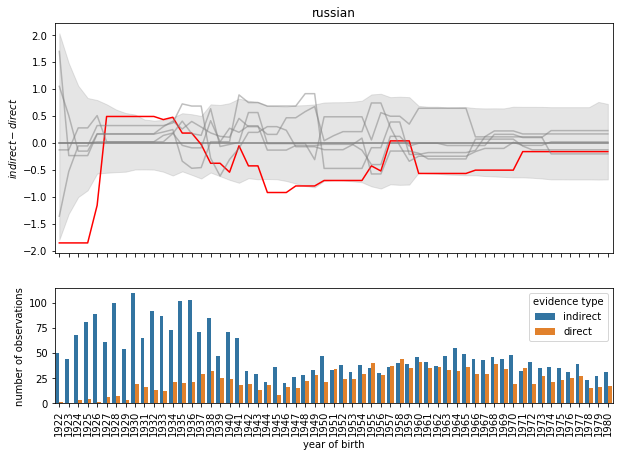

In [12]:
plot_delta(
    delta_russian_perm,
    delta_russian_full_logodds,
    data_russian,
    title="russian",
)

The following figure is not included into the paper. 
Here confidence bands are obtained not from null distribution, but from bootstrapped distribution of imputed true difference. One can see that this figure is consistent with the previous one.

In [13]:
# plot_delta(
#     delta_russian_bootstrap,
#     delta_russian_full_logodds,
#     data_russian,
#     title="delta (Russian, log odds)",
# )

statistics value: -0.39864068766905963
statistics value: -0.3499545125256619
statistics value: -0.4320254934816752


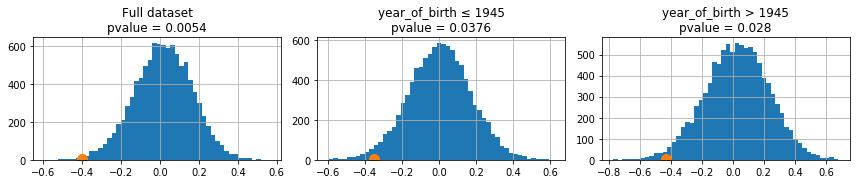

In [14]:
test_all_hyps(
    delta_russian_full_logodds,
    delta_russian_perm,
    statistics=(("systematic bias", "delta", identity, np.mean),),
    queries=(None, "year_of_birth <= 1945", "year_of_birth > 1945"),
    figsize=(12, 8 / 3),
)
plt.tight_layout()
plt.savefig("russian-systematic-bias.pdf")

In [15]:
[round(x, 2) for x in ci(delta_russian_bootstrap.groupby("iter")["delta"].mean())]

[-0.7, -0.08]

### Interpretation of effect size in terms of probability

In [16]:
def odds_to_prob(x):
    return x / (1 + x)


def prob_to_odds(p):
    return p / (1 - p)

In [17]:
odds_to_prob(np.exp(0.4) * prob_to_odds(0.01))

0.014845234446979709

## ITM

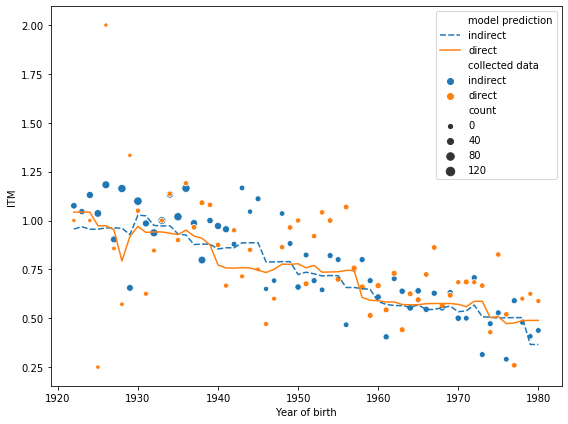

In [18]:
plot_pred_data(
    data=data_itm,
    full=pred_itm_full,
    target="number of lang",
    ylabel="ITM",
    ylim=None,
    ylogodds=False,
)
plt.tight_layout()
# plt.savefig("plot_pred_data_rusian.png")

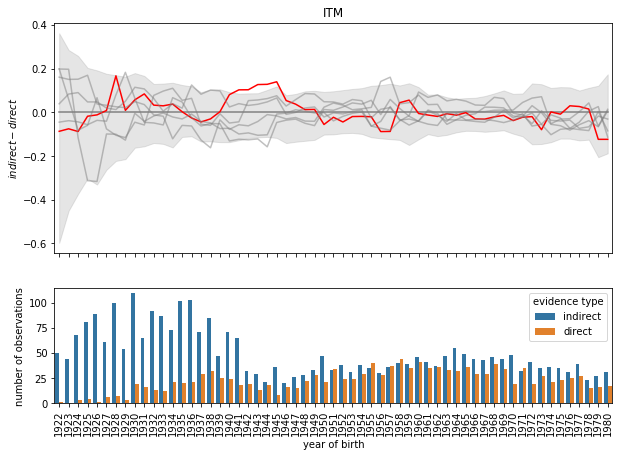

In [19]:
plot_delta(delta_itm_perm, delta_itm_full, data_itm, title="ITM")

In [20]:
# plot_delta(delta_itm_bootstrap, delta_itm_full, data_itm, title="delta (ITM)")

statistics value: 0.002112200375158709
statistics value: 0.03103648364884533
statistics value: -0.01772159386965498


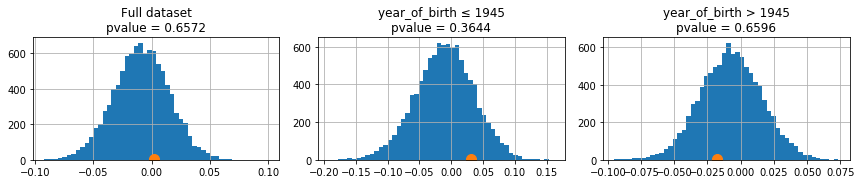

In [21]:
test_all_hyps(
    delta_itm_full,
    delta_itm_perm,
    statistics=(("systematic bias", "delta", identity, np.mean),),
    figsize=(12, 8 / 3),
)
plt.tight_layout()
plt.savefig("itm-systematic-bias.pdf")

statistics value: 0.19128029081654213
statistics value: 0.23400098846028483
statistics value: 0.16198609814654708


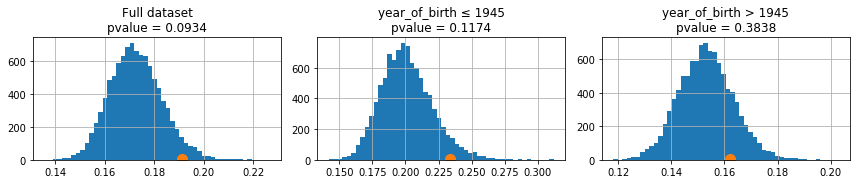

In [22]:
test_all_hyps(
    delta_itm_full,
    delta_itm_perm,
    statistics=(("cumulative bias", "delta_absolute", np.abs, np.mean),),
    figsize=(12, 8 / 3),
)
plt.tight_layout()
plt.savefig("itm-cumulative-bias.pdf")

In [23]:
tuple([round(x, 2) for x in ci(delta_itm_bootstrap.groupby("iter")["delta"].mean())])

(-0.05, 0.04)

statistics value: -0.39864068766905963


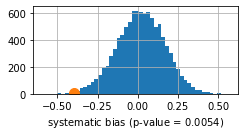

In [24]:
plt.figure(figsize=(3.5, 2))
stat_value, pvalue = test_hyp(
    delta_russian_full_logodds,
    delta_russian_perm,
    plt.gca(),
    stat_column="delta",
    stat_function=identity,
    agg_function=np.mean,
)
plt.xlabel(f"systematic bias (p-value = ${pvalue}$)")
plt.tight_layout()
plt.savefig("russian-systematic-bias.pdf")

statistics value: 0.002112200375158709
statistics value: 0.19128029081654213


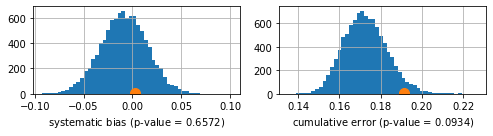

In [25]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(7, 2), )

_, pvalue = test_hyp(
    delta_itm_full,
    delta_itm_perm,
    ax1,
    stat_column="delta",
    stat_function=identity,
    agg_function=np.mean,
)

ax1.set_xlabel(f"systematic bias (p-value = ${pvalue}$)")

_, pvalue = test_hyp(
    delta_itm_full,
    delta_itm_perm,
    ax2,
    stat_column="delta_absolute",
    stat_function=np.absolute,
    agg_function=np.mean,
)

ax2.set_xlabel(f"cumulative error (p-value = ${pvalue}$)")
fig.align_labels()
plt.tight_layout()
plt.savefig("itm-systematic-bias-and-cumulative-error.pdf")

In [26]:
ax1.set_x

AttributeError: 'AxesSubplot' object has no attribute 'set_x'